# Make Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
!ls ../data/ccsTemp

tempR11-Run6.csv tempR21-Run6.csv tempR30-Run6.csv tempR34-Run6.csv
tempR12-Run6.csv tempR22-Run6.csv tempR31-Run6.csv
tempR13-Run6.csv tempR23-Run6.csv tempR32-Run6.csv
tempR14-Run6.csv tempR24-Run6.csv tempR33-Run6.csv


In [3]:
!head ../data/ccsTemp/tempR11-Run6.csv

#
# None
#
# CCS trending dump at 2023-06-30T20:10:24-07:00
# Data for 1209600 total seconds from 1 intervals over 14 days, 0:00:00 (h:m:s) from:
#     tmin=1686677400000.0: "2023-06-13T10:30:00-07:00"
#     tmax=1687887000000.0: "2023-06-27T10:30:00-07:00"
# 'time (ms)'       'value' 'unit'  'channel CCS path'              'iso-8601 Date'               
1686677407924     -99.69018     °C   focal-plane/R11/Reb0/S00/Temp   2023-06-13T10:30:07.924-07:00 
1686677416924     -99.53133     °C   focal-plane/R11/Reb0/S00/Temp   2023-06-13T10:30:16.924-07:00 


In [4]:
path = '../data/ccsTemp/'
regex = path+'temp%s-Run6.csv'

In [5]:
def read_file(fname, start_date, end_date):
    # fast reading
    dt1 = np.dtype({'names': ['time', 'temp', 'channel','datetime'],
                'formats': [int , float, 'U28', 'U28']})
    rdata = np.loadtxt(fname, dt1, usecols=(0, 1, 3, 4))
    
    # convert to dataframe
    df = pd.DataFrame(rdata)
    
    # convert datetime to a time-series
    df['datetime'] = pd.to_datetime(df['datetime'])#.dt.strftime('%d-%m %H:%M:%S')
    df = df.set_index('datetime')
    # make sensor, raft-sensor columns
    df['raft-sensor'] = df['channel'].apply(lambda x: '-'.join([x.split('/')[1],x.split('/')[3]]))
    df['sensor'] = df['channel'].apply(lambda x: x.split('/')[3])
    df = df.drop('channel',axis=1)
    df = df.drop('time',axis=1)
    
    mask = (df.index >= start_date) & (df.index <= end_date)
    dfmask = df.loc[mask]
    
    
    return dfmask.sort_index()

In [68]:
end_date = '2023-06-26 04:00:00'
start_date = '2023-06-24 18:30:43'

df = read_file(regex%'R33',start_date, end_date)
df

,temp,raft-sensor,sensor
datetime,,,
2023-06-24 18:30:46.511000-07:00,-101.77460,R33-S20,S20
2023-06-24 18:30:46.518000-07:00,-100.44630,R33-S21,S21
2023-06-24 18:30:46.524000-07:00,-98.87553,R33-S22,S22
2023-06-24 18:30:48.099000-07:00,-101.64370,R33-S10,S10
2023-06-24 18:30:48.106000-07:00,-95.90582,R33-S11,S11
...,...,...,...
2023-06-26 03:26:54.106000-07:00,-96.60436,R33-S11,S11
2023-06-26 03:26:54.113000-07:00,-101.24610,R33-S12,S12
2023-06-26 03:26:56.276000-07:00,-101.41520,R33-S00,S00


In [69]:
def group_temps(df):
    df_pivot = df.pivot_table(index=df.index, columns='raft-sensor', values='temp', aggfunc='mean')
    df_pivot.columns = ['Temp_' + col for col in df_pivot.columns]
    df_merged = df.merge(df_pivot, left_index=True, right_index=True)
    df_merged = df_merged.resample('10s').mean()
    df_merged = df_merged.drop('temp',axis=1)
    return df_merged

In [70]:
dfn = group_temps(df)
dfn

,Temp_R33-S00,Temp_R33-S01,Temp_R33-S02,Temp_R33-S10,Temp_R33-S11,Temp_R33-S12,Temp_R33-S20,Temp_R33-S21,Temp_R33-S22
datetime,,,,,,,,,
2023-06-24 18:30:40-07:00,NaN,NaN,NaN,-101.6437,-95.90582,-100.69800,-101.7746,-100.4463,-98.87553
2023-06-24 18:30:50-07:00,-101.6042,-101.20850,-100.217805,-101.9669,-96.26624,-100.67110,-101.7300,-100.4547,-98.82072
2023-06-24 18:31:00-07:00,-101.1783,-102.03190,-99.993000,-101.8443,-96.19378,-99.67253,-101.8954,-100.5178,-98.42408
2023-06-24 18:31:10-07:00,-101.8322,-101.16900,-100.613500,-101.8620,-96.22072,-100.17970,-101.6065,-100.6089,-99.03066
2023-06-24 18:31:20-07:00,-101.4495,-101.40680,-100.180600,-102.3153,-96.28760,-100.76030,-101.2749,-100.4454,-98.73526
...,...,...,...,...,...,...,...,...,...
2023-06-26 03:26:10-07:00,-101.9892,-101.51550,-100.868000,-102.8039,-96.54119,-100.29580,-102.1323,-100.4361,-99.06688
2023-06-26 03:26:20-07:00,-102.2767,-101.65895,-100.462550,-102.5438,-96.83566,-101.39750,-101.7876,-100.7658,-99.04087
2023-06-26 03:26:30-07:00,-101.6325,-102.00220,-100.280000,-102.4602,-97.24716,-101.27490,-102.1248,-101.3297,-98.91361


In [162]:
def pick(df, labels):
    nsize = [len(df.columns[labels==i]) for i in range(2)]
    good = list(df.columns[labels == np.argmax(nsize)])
    bad = list(df.columns[labels == np.argmin(nsize)])
    return good, bad

# group bw bad and good
# interpolate nan values
_df = dfn.resample('5min').mean().interpolate()
labels = get_groups(_df)

In [164]:
good, bad = pick(_df, labels)
bad

['Temp_R33-S11', 'Temp_R33-S22']

In [193]:
def to_dict_bad_sensors_report(df, bad_sensors):
    raft = bad_sensors[0].split('-')[0]
    tmean, tstd = np.round(df['T_%s_mean'%raft].mean(),5), np.round(df['T_%s_std'%raft].mean(),5)
    columns = ['Delta_Temp_%s'%col for col in bad_sensors]
    offsets = [np.round(df[col].mean(),5) for col in columns]
    out = {'raft':raft, 'sensor-list':bad_sensors, 
           'tmean':tmean, 'tstd':tstd, 'offset-list':offsets}
    return out

def write_dict_to_csv(filename, out):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Raft', 'Sensor', 'Tmean', 'Tstd', 'Offset'])
        for i in range(len(out['sensor-list'])):
            writer.writerow([out['raft'], out['sensor-list'][i], out['tmean'], out['tstd'], out['offset-list'][i]])


In [194]:
out = to_dict_bad_sensors_report(dfn2, bad_sensors)
out

{'raft': 'R33',
 'sensor-list': ['R33-S11', 'R33-S22'],
 'tmean': -101.2303,
 'tstd': 0.64198,
 'offset-list': [4.81869, 2.29719]}

In [195]:
def bad_sensors_repport(mydict):
    str_offsets = ', '.join('%.3f'%num for num in mydict['offset-list']) 
    print(6*'-----')
    print('%s Sensors RTD Temp Summary'%mydict['raft'])
    print('Good Sensors [C]')
    print('mean, std: %.3f, %.3f\n'%(mydict['tmean'], mydict['tstd']))
    print('Bad Sensors')
    print('sensor-name : '+', '.join(mydict['sensor-list']))
    print('Temp. Offset: '+ str_offsets)
    print(6*'-----')

bad_sensors_repport(out)

------------------------------
R33 Sensors RTD Temp Summary
Good Sensors [C]
mean, std: -101.230, 0.642

Bad Sensors
sensor-name : R33-S11, R33-S22
Temp. Offset: 4.819, 2.297
------------------------------


In [197]:
def write_dict_to_csv(filename, out):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Raft', 'Sensor', 'Tmean', 'Tstd', 'Offset'])
        for i in range(len(out['sensor-list'])):
            writer.writerow([out['raft'], out['sensor-list'][i], out['tmean'], out['tstd'], out['offset-list'][i]])
    print('Saved file: %s'%filename)
write_dict_to_csv('output.csv', out)

Saved file: output.csv


In [187]:
filename = 'output.csv'  # Specify the filename or path for the CSV file
with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Raft', 'Sensor', 'Tmean', 'Tstd', 'Offset'])
    for i in range(len(out['sensor-list'])):
        writer.writerow([raft, out['sensor-list'][i], tmean, tstd, out['offset-list'][i]])

In [148]:
from sklearn.cluster import KMeans

def get_groups(df):
    x = df.to_numpy().T
    kmeans = KMeans(n_clusters=2, random_state=0).fit(x)
    labels = kmeans.labels_
    return labels

def create_dT_cols(df, tmean, tstd):
    columns_to_subtract = [col for col in df.columns if 'Temp_R' in col]

    for col in columns_to_subtract:
        df[r'Delta_'+col] = df[col] - tmean
        df[r'Delta_STD_'+col] = (df[col] - tmean)/tstd
    return df

def bad_sensors_repport(df, bad_sensors):
    # raft name
    raft = list(df.columns)[0].split('_')[1][:3]
    tmean, tstd = dfn2['T_%s_mean'%raft].mean(), dfn2['T_%s_std'%raft].mean()
    columns = ['Delta_Temp_%s'%col for col in bad_sensors]
    offsets = [dfn2[col].mean() for col in columns]

    bad_sensors = [si.split('-')[1] for si in bad_sensors]
    str_offsets = ', '.join('%.3f'%num for num in offsets)
    print(6*'-----')
    print('%s Sensors RTD Temp Summary'%raft)
    print('Good Sensors [C]')
    print('mean, std: %.3f, %.3f\n'%(tmean, tstd))
    print('Bad Sensors')
    print('sensor-name : '+', '.join(bad_sensors))
    print('Temp. Offset: '+ str_offsets)
    print(6*'-----')
    
def get_robust_mean(df):
    # raft name
    raft = list(df.columns)[0].split('_')[1][:3]
    
    # interpolate nan values
    df = df.resample('5min').mean().interpolate()
    
    # group bw bad and good
    labels = get_groups(df)
    
    good_sensors = list(df.columns[labels==1])
    bad_sensors = list(df.columns[labels==0])
    
    # take the mean, std of the good sensors
    df['T_%s_mean'%raft] = df[good_sensors].mean(axis=1)
    df['T_%s_std'%raft] = df[good_sensors].std(axis=1)
    
    # create delta T columns with subtraction over the mean
    df = create_dT_cols(df, df['T_%s_mean'%raft], df['T_%s_std'%raft])
    
    # put only RXX-SXX
    bad_RXXSXX = [si.split('_')[1] for si in bad_sensors]
    return df, bad_RXXSXX

In [150]:
dfn2, bad_sensors = get_robust_mean(dfn)
dfn2

,Temp_R33-S00,Temp_R33-S01,Temp_R33-S02,Temp_R33-S10,Temp_R33-S11,Temp_R33-S12,Temp_R33-S20,Temp_R33-S21,Temp_R33-S22,T_R33_mean,...,Delta_Temp_R33-S11,Delta_STD_Temp_R33-S11,Delta_Temp_R33-S12,Delta_STD_Temp_R33-S12,Delta_Temp_R33-S20,Delta_STD_Temp_R33-S20,Delta_Temp_R33-S21,Delta_STD_Temp_R33-S21,Delta_Temp_R33-S22,Delta_STD_Temp_R33-S22
datetime,,,,,,,,,,,,,,,,,,,,,
2023-06-24 18:30:00-07:00,-101.562550,-101.330976,-100.115408,-101.854690,-96.221991,-100.544364,-101.550338,-100.433585,-98.701038,-101.055987,...,4.833997,7.142408,0.511623,0.755942,-0.494351,-0.730422,0.622402,0.919622,2.354949,3.479524
2023-06-24 18:35:00-07:00,-101.499870,-101.209402,-100.188609,-101.808690,-96.241514,-100.638037,-101.594938,-100.580848,-98.701622,-101.074342,...,4.832828,7.930801,0.436305,0.715989,-0.520596,-0.854313,0.493494,0.809836,2.372720,3.893698
2023-06-24 18:40:00-07:00,-101.435527,-101.273805,-100.156786,-101.901228,-96.184014,-100.593671,-101.617377,-100.443455,-98.747944,-101.060264,...,4.876250,7.381408,0.466593,0.706304,-0.557113,-0.843327,0.616809,0.933693,2.312320,3.500267
2023-06-24 18:45:00-07:00,-101.504372,-101.217643,-100.276764,-101.813132,-96.170314,-100.556185,-101.547583,-100.430889,-98.674096,-101.049510,...,4.879196,7.898558,0.493325,0.798606,-0.498074,-0.806293,0.618620,1.001437,2.375413,3.845375
2023-06-24 18:50:00-07:00,-101.463248,-101.231777,-100.116673,-101.764687,-96.184928,-100.572306,-101.670353,-100.401208,-98.751939,-101.031465,...,4.846536,7.338114,0.459158,0.695209,-0.638889,-0.967338,0.630257,0.954268,2.279526,3.451418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26 03:05:00-07:00,-101.889297,-101.755317,-100.797743,-102.319023,-96.701492,-101.180660,-102.102487,-101.065302,-99.294248,-101.587118,...,4.885627,8.501552,0.406458,0.707284,-0.515368,-0.896800,0.521817,0.908021,2.292871,3.989859
2023-06-26 03:10:00-07:00,-102.040810,-101.798315,-100.739319,-102.201147,-96.928640,-101.106622,-102.203135,-100.987097,-99.270685,-101.582349,...,4.653709,7.489675,0.475728,0.765635,-0.620786,-0.999092,0.595253,0.957999,2.311665,3.720391
2023-06-26 03:15:00-07:00,-102.115422,-101.779848,-100.684007,-102.317500,-96.773002,-101.052562,-102.121928,-100.980152,-99.232877,-101.578774,...,4.805772,7.293467,0.526212,0.798605,-0.543154,-0.824317,0.598622,0.908498,2.345897,3.560244


In [151]:
bad_sensors_repport(dfn2, bad_sensors)

------------------------------
R33 Sensors RTD Temp Summary
Good Sensors [C]
mean, std: -101.230, 0.642

Bad Sensors
sensor-name : S11, S22
Temp. Offset: 4.819, 2.297
------------------------------


<AxesSubplot:xlabel='datetime'>

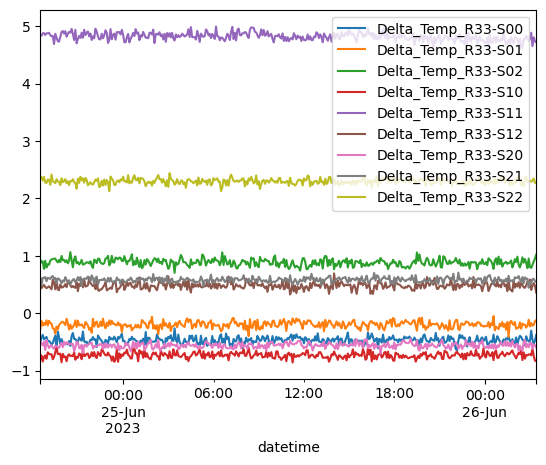

In [87]:
columns = [col for col in dfn2.columns if r'Delta_Temp' in col]
dfn2[columns].plot()

<AxesSubplot:xlabel='datetime'>

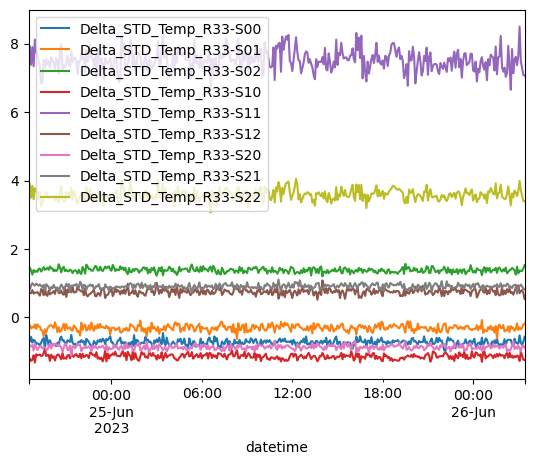

In [88]:
columns = [col for col in dfn2.columns if r'Delta_STD_Temp' in col]
dfn2[columns].plot()

<AxesSubplot:xlabel='datetime'>

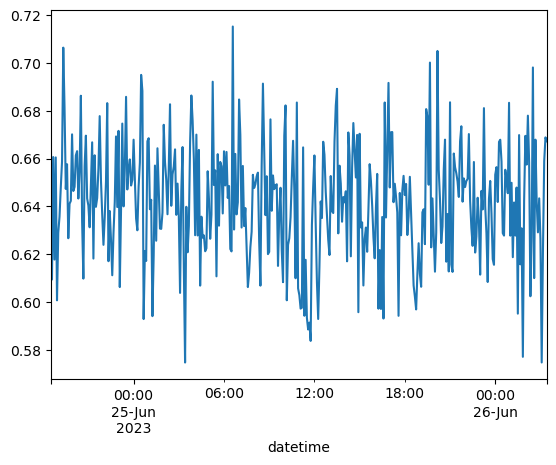

In [92]:
dfn2['T_R33_std'].plot()

In [152]:
dfn2.metadata = {"bad_sensors":bad_sensors}

/var/folders/6w/mvq682kn30zd7qxmn0lmt4q00000gs/T/ipykernel_92401/1265849676.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dfn2.metadata = {"bad_sensors":bad_sensors}


In [158]:
dfn2.columns

Index(['Temp_R33-S00', 'Temp_R33-S01', 'Temp_R33-S02', 'Temp_R33-S10',
       'Temp_R33-S11', 'Temp_R33-S12', 'Temp_R33-S20', 'Temp_R33-S21',
       'Temp_R33-S22', 'T_R33_mean', 'T_R33_std', 'Delta_Temp_R33-S00',
       'Delta_STD_Temp_R33-S00', 'Delta_Temp_R33-S01',
       'Delta_STD_Temp_R33-S01', 'Delta_Temp_R33-S02',
       'Delta_STD_Temp_R33-S02', 'Delta_Temp_R33-S10',
       'Delta_STD_Temp_R33-S10', 'Delta_Temp_R33-S11',
       'Delta_STD_Temp_R33-S11', 'Delta_Temp_R33-S12',
       'Delta_STD_Temp_R33-S12', 'Delta_Temp_R33-S20',
       'Delta_STD_Temp_R33-S20', 'Delta_Temp_R33-S21',
       'Delta_STD_Temp_R33-S21', 'Delta_Temp_R33-S22',
       'Delta_STD_Temp_R33-S22'],
      dtype='object')

In [ ]:
pd.wri